# E5-1-1. 음성데이터 classification 모델(Conv1D) 구현  
- 1차원 시계열 데이터로 해석하는 waveform해석에 대한 코드
- waveform은 여러 파형이 합성된 복합파인데, 다양한 파형들을 주파수 대역별로 나누어 별도로 해석할 수 있는 방법이 있지 않을까?
    - E5-2-1. Spectrogram 모델에서 다룰 것임
### A. 데이터 준비 및 분석
#### 데이터 다운 (1.6G 대용량)
- mkdir -p ~/aiffel/speech_recognition/data
- mkdir -p ~/aiffel/speech_recognition/models
- wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz 
- -P ~/aiffel/speech_recognition/data

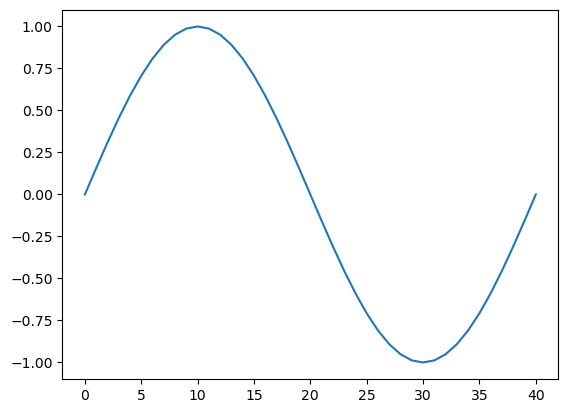

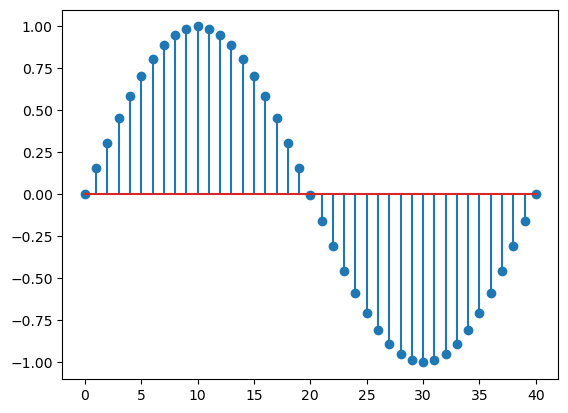

In [1]:
#### 0. 오디오 데이터 표본화 ############################################################################
import numpy as np
import matplotlib.pyplot as plt

def single_tone(frequecy, sampling_rate=16000, duration=1):
    t = np.linspace(0, duration, int(sampling_rate))
    y = np.sin(2 * np.pi * frequecy * t)
    return y

y = single_tone(400)

# 1 사이클 동안 나타나는 연속시간 연속크기 아날로그 신호인 간단한 사인함수
plt.plot(y[:41])
plt.show()

# 1 사이클 동안 나타나는 이산시간 연속크기 신호
plt.stem(y[:41])
plt.show()

- 음성데이터를 디지털화 하는 과정( 표본화 -> 양자화 -> 부호화 ) : wav
<img src = "https://user-images.githubusercontent.com/76797423/206318831-0fa4994b-864f-4dcd-943b-b935f8cc6d21.png">

In [1]:
#### 1. 데이터 로드 ####################################################################################
import numpy as np
import os

#data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load('speech_wav_8000.npz')
for i in speech_data:
    print(i)

wav_data = speech_data["wav_vals"]
label_data = speech_data["label_vals"]

# 1초 길이의 오디오 데이터 50620개, 1개 당 8000가지의 sample data 보유
print("Wave data shape : ", speech_data["wav_vals"].shape) # 8000*1사이즈(데이터의 feature) 데이터 50620개 = 50620*8000 행렬
print("Label data shape : ", speech_data["label_vals"].shape) # 데이터 개수만큼 라벨(정답지) 존재 = 50620*1 행렬

wav_vals
label_vals
Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [2]:
#### 2. 데이터 확인 ####################################################################################
import IPython.display as ipd
import random

## 전체 데이터 50260개 중, 1개의 데이터 랜덤 추출 : 라벨과 맞는지 확인
rand = random.randint(0, len(speech_data["wav_vals"]))
print("random number : ", rand)
data_sample = wav_data[rand] 
label_sample = label_data[rand]
print("Wave data shape : ", data_sample.shape)
print("label data shape : ", label_sample.shape)
print("label : ", label_sample)
print("wave data : ")

## rate = data의 feature 수 (1초동안 재생되는 샘플 수)
ipd.Audio(data_sample, rate=data_sample.shape[0]) 

random number :  33062
Wave data shape :  (8000,)
label data shape :  (1,)
label :  ['on']
wave data : 


### B. train/test 데이터셋 생성

In [3]:
#### 3. 라벨 데이터 처리 ####################################################################################
## Text 형태의 라벨 데이터에 학습에 사용 가능한 index 부여
## unknown, silence는 구분되지 않는 데이터의 라벨
label_value = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i    
label_value = new_label_value
print('Indexed LABEL : ', new_label_value)
# {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [4]:
## label = speech_data["label_vals"]를 위에 생성해준 dict.. label_value에 해당하는 값으로 변경
## 예를들어 라벨이 yes였던 걸 0으로 바꿔주는 작업
temp = []
for v in label_data:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
print(label_data.shape, label_data)
## array([ 3,  3,  3, ..., 11, 11, 11])

(50620,) [ 3  3  3 ... 11 11 11]


In [5]:
#### 4. 데이터 분리 ####################################################################################
## sklearn의 train_test_split 함수 이용 : train data와 test data 분리  
## test_size의 인자를 조절해주면, 설정해 준 값만큼 Test dataset의 비율을 조정 가능
from sklearn.model_selection import train_test_split

## 음성데이터를 source로 두고 분리, indexed label data를 타겟으로 두고
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav.shape, test_wav.shape)  # (45558, 8000) (5062, 8000)

train_wav = train_wav.reshape([-1, 8000, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, 8000, 1])
print(train_wav.shape, test_wav.shape)  # (45558, 8000, 1) (5062, 8000, 1)

(45558, 8000) (5062, 8000)
(45558, 8000, 1) (5062, 8000, 1)


In [6]:
#### 5. 데이터셋 생성 ####################################################################################
## map : dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해줌
import tensorflow as tf

## 배치사이즈 커지면 메모리 사용량 증가, 경험상 학습에는 배치사이즈가 큰 영향 안 주는 듯
batch_size = 10 

## one-hot-encoding map 사용
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
    
# for train
## 데이터를 [source, target] 쌍으로 엮어줌
## repeat(n) : n-interation per 1 ep., () means infinitely many
## #(data) / batch-size = n-interation(or n-step) per 1 ep.
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))  
train_dataset = train_dataset.map(one_hot_label) 
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-07 21:39:40.872140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-07 21:39:40.872429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### C. 모델 구현
- Audio 데이터는 1차원 데이터이기 때문에 Conv1D layer를 이용해서 모델을 구성

In [7]:
#### 6. model construction ####################################################################################
from keras.layers import Input, Conv1D, MaxPool1D, Dropout, Flatten, Dense, BatchNormalization, Activation
from keras import Model
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

def wav_model(input_shape):
    input_tensor = Input(shape=input_shape)
    x = Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
    x = Conv1D(32, 9, padding='same', activation='relu')(x)
    x = MaxPool1D()(x)

    x = Conv1D(64, 9, padding='same', activation='relu')(x)
    x = Conv1D(64, 9, padding='same', activation='relu')(x)
    x = MaxPool1D()(x)

    x = Conv1D(128, 9, padding='same', activation='relu')(x)
    x = Conv1D(128, 9, padding='same', activation='relu')(x)
    x = Conv1D(128, 9, padding='same', activation='relu')(x)
    x = MaxPool1D()(x)

    x = Conv1D(256, 9, padding='same', activation='relu')(x)
    x = Conv1D(256, 9, padding='same', activation='relu')(x)
    x = Conv1D(256, 9, padding='same', activation='relu')(x)
    x = MaxPool1D()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    output_tensor = Dense(12)(x)
    model = Model(input_tensor, output_tensor)
    opt = Adam(1e-4)  # 1e-4 : 0.0001
    model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=['accuracy'])
    return model

- callback 함수가 무엇인가?
    - 모델 학습을 진행하며, fit함수내 다양한 인자를 지정해 모니터하며 동작하도록 설정 
    - 아래 코드에서 콜백은 validation loss를 모니터하며, loss가 낮아지면 모델 파라미터를 저장하도록 구성

In [8]:
#### 7. Model Checkpoint Callback ############################################################################
checkpt_dir = '/Users/yoonjeongyang/Desktop/signal/networks/'
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpt_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 save_freq='epoch',
                                                 verbose=1)

### D. 학습
- 메모리 부족 시, 배치사이즈 줄일 것

In [10]:
#### 8. model fit ###########################################################################################
## fit 함수는 학습결과를 리턴하고, 그 결과를 history_wav에 저장
input_shape = train_dataset.element_spec[0].shape[1:]
print("Input Shape = ", input_shape)
model = wav_model(input_shape) 
history_wav = model.fit(train_dataset, epochs=2,
                    steps_per_epoch=len(train_wav) // batch_size, 
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Input Shape =  (8000, 1)
Epoch 1/2


2022-12-07 21:44:05.906092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1033/4555 [=====>........................] - ETA: 9:05 - loss: 2.2549 - accuracy: 0.2078

KeyboardInterrupt: 

### E. 학습결과 시각화
- train_loss와 val_loss의 차이가 커진다면 overfitting일 수 있음

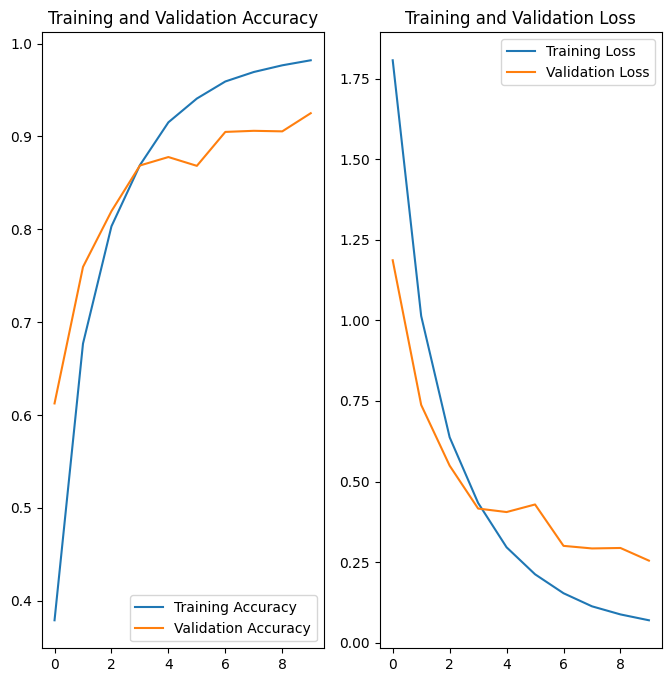

In [10]:
#### 9. accuracy, loss 비교 시각화 ###########################################################################
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### F. Evaluation (평가)

In [11]:
#### 10. accuracy, loss #####################################################################################
model.load_weights(checkpt_dir)
results = model.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

507/507 [==============================] - 5s 9ms/step - loss: 0.2546 - accuracy: 0.9251
loss value: 0.255
accuracy value: 92.5128%


### G. 모델 테스트

In [64]:
#### 11. Test data 셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인 #########################################
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  go


In [65]:
#### 12. 테스트셋의 라벨과 모델의 실제 prediction 결과 비교 ####################################################
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + "(Correct!)")
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + "(Incorrect!)")

y_pred: stop(Incorrect!)


------------------------------------
### Skip-Connection model로 적용
- Skip-Connection 추가하여 1D 모델 만들기 (residual block 만든 거 추가)
- [skip-conn. 참고 1](https://lv99.tistory.com/25)
- [skip-conn. 참고 2](https://m.blog.naver.com/laonple/221259295035)
  
### Spectrogram
- waveform 데이터를 1차원 시계열 데이터로 해석하여 적용한 코드
- waveform은 여러 파형이 합성된 복합파인데, 다양한 파형들을 주파수 대역별로 나누어 별도로 해석할 수 있는 방법이 있지 않을까?
- Waveform 데이터 대신 이 Spectrogram 포맷으로 모든 음성 데이터를 변환한 후 음성인식 모델을 학습시킨다면, 과연 Waveform과 비교했을 때 더 나은 성능을 기대할 수 있을까?
- E5-2-1 파일 확인
  
### 푸리에 변환 Fourier transform
- [푸리에 변환의 이해와 활용](https://darkpgmr.tistory.com/171)
- 임의의 입력 신호를 다양한 주파수를 갖는 주기함수들의 합으로 분해하여 표현하는 것
  
### STFT(Short Time Fourier Transform) = 국소적 푸리에 변환
- 시간의 길이를 나누어 푸리에 변환 (즉, 어떤 시간에 주파수가 변했는지를 체크하기 위함)
- [STFT 기본 1](https://jbear.tistory.com/entry/STFT-Short-Time-Furier-Transform-%EC%9D%98-%EA%B8%B0%EB%B3%B8?category=398516)
- [STFT 기본 2](https://jbear.tistory.com/entry/STFT-Short-Time-Furier-Transform-%EC%9D%98-%EA%B8%B0%EB%B3%B8%EA%B0%9C%EB%85%90-2?category=398516)
-------------------------------------
